In [4]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# === SETUP ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_dir = '/content/drive/MyDrive/245project/openimages_dataset_small/val'
batch_size = 32
num_classes = 2
class_names = ['harmful', 'safe']

# === TRANSFORM ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# === LOAD DATA ===
val_dataset = ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
# === HELPER FUNCTION TO LOAD MODEL ===
def load_model(model_path, model_type='mobilenet'):
    if model_type == 'mobilenet':
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    elif model_type == 'resnet':
        model = models.resnet50(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError("Unknown model type")

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# === EVALUATION FUNCTION ===
def evaluate_model(model, dataloader):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# === LOAD & EVALUATE BOTH MODELS ===
mobilenet_model = load_model('/content/drive/MyDrive/245project/mobilenetv2_simple.pth', 'mobilenet')
resnet_model = load_model('/content/drive/MyDrive/245project/resnet50_harmful_safe.pth', 'resnet')

labels_mob, preds_mob = evaluate_model(mobilenet_model, val_loader)
labels_res, preds_res = evaluate_model(resnet_model, val_loader)

# === METRICS ===
def print_metrics(true, pred, model_name):
    print(f"\n==== {model_name} ====")
    print("Accuracy:", accuracy_score(true, pred))
    print("Classification Report:\n", classification_report(true, pred, target_names=class_names))

print_metrics(labels_mob, preds_mob, "MobileNetV2")
print_metrics(labels_res, preds_res, "ResNet50")


==== MobileNetV2 ====
Accuracy: 0.8352941176470589
Classification Report:
               precision    recall  f1-score   support

     harmful       0.87      0.79      0.83       680
        safe       0.80      0.89      0.84       680

    accuracy                           0.84      1360
   macro avg       0.84      0.84      0.83      1360
weighted avg       0.84      0.84      0.83      1360


==== ResNet50 ====
Accuracy: 0.8220588235294117
Classification Report:
               precision    recall  f1-score   support

     harmful       0.96      0.68      0.79       680
        safe       0.75      0.97      0.84       680

    accuracy                           0.82      1360
   macro avg       0.85      0.82      0.82      1360
weighted avg       0.85      0.82      0.82      1360



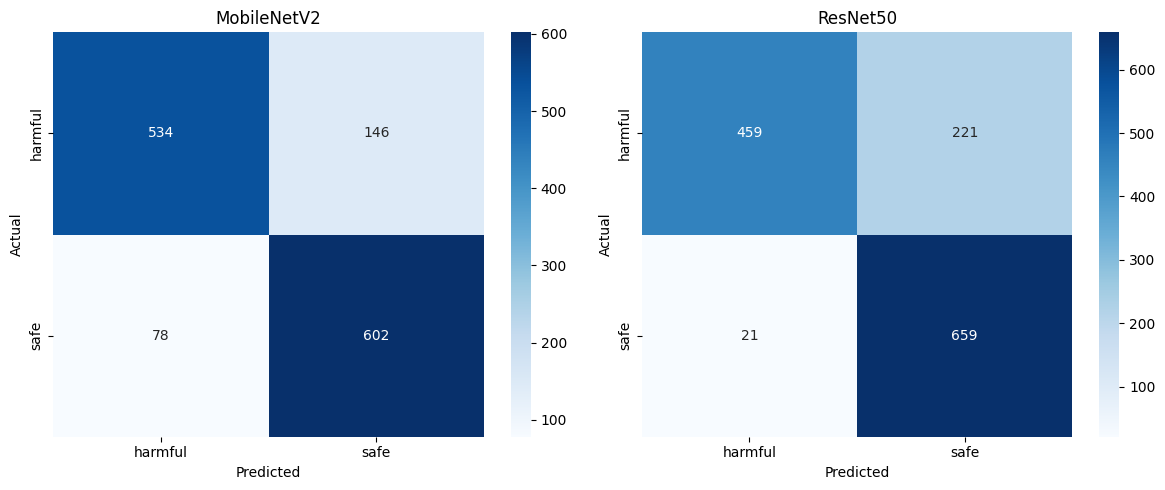

In [8]:
# === CONFUSION MATRIX PLOTS ===
def plot_conf_matrices(true1, pred1, true2, pred2, labels):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    cm1 = confusion_matrix(true1, pred1)
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=labels, yticklabels=labels)
    axes[0].set_title('MobileNetV2')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    cm2 = confusion_matrix(true2, pred2)
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=axes[1], xticklabels=labels, yticklabels=labels)
    axes[1].set_title('ResNet50')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

plot_conf_matrices(labels_mob, preds_mob, labels_res, preds_res, class_names)

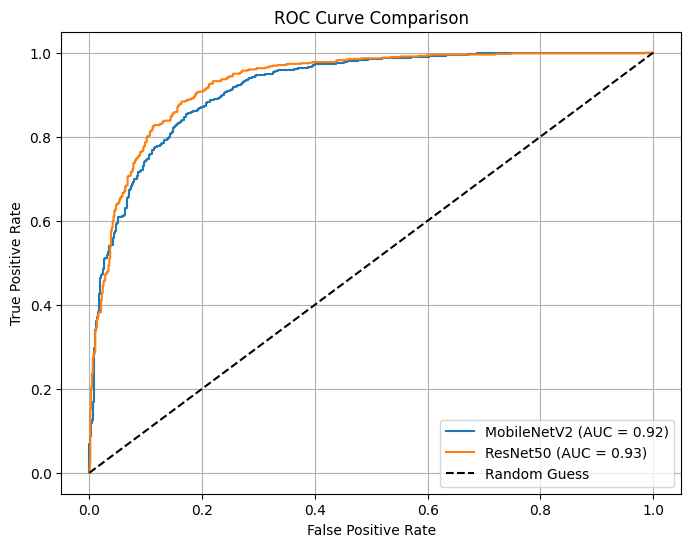

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(model, dataloader, model_name):
    all_labels = []
    all_probs = []

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # probability of class "safe"
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    auc_score = roc_auc_score(all_labels, all_probs)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')
    return auc_score

plt.figure(figsize=(8, 6))
auc1 = plot_roc_curve(mobilenet_model, val_loader, 'MobileNetV2')
auc2 = plot_roc_curve(resnet_model, val_loader, 'ResNet50')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()
